---
title: Structured Approach to ML Projects
order: 2
author: Aniruddha
---

## Objective  

- To understand and practice building effective end-to-end machine learning models using this notebook as a companion to the lecture.
- Some pointers have been provided after various code snippets. These are not specific to this dataset.

## Instructions

- Clearly explain how each method or function used in the notebook works.  
- For every code snippet, document the key insights and takeaways.  

## Imports

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Reading the Dataset

In [48]:
sample_submission = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")

### Pointers

- We are using `read_csv` from **pandas** to read the file into a DataFrame.  
- Some formats in which data can be stored include formats such as `.tsv`, `.xlsx`, or in SQL Databases. Look up how to read these file types and try loading files as an exercise.  
- Sometimes data might have to be converted to a tabular format. As an exercise, practice converting and handling data in **JSON** format as well.  


In [49]:
print(f'The shape of the training data is {train.shape}')
print(f'The shape of the test data is {test.shape}')

The shape of the training data is (58645, 13)
The shape of the test data is (39098, 12)


In [50]:
# View the first few rows of the dataset
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


## Description of Features
1. person_age: The age of the loan applicant in years
2. person_income: Income of the applicant 
3. person_home_ownership: Status of home ownership among Rent, Own, Mortagage and others   
4. person_emp_length: Length of employment in years
5. loan_intent: Purpose of the loan
6. loan_grade: Some metric assigning a quality score to the loan 
7. loan_amnt: Loan amount requested by the candidate
8. loan_int_rate: Interest rate associated with the loan
9. loan_percent_income: Percentage of income to be used for loan payments? 
10. cb_person_default_on_file: Indication of whether the applicant has defaulted earlier
11. cb_person_cred_hist_length: Length of applicant's credit history in years
12. loan_status: Approval / Rejection of the loan (Target Variable)

### Pointers
- Use domain knowledge and prior work for guidance, but avoid letting assumptions overly influence decisions.  
- Allow the data to reveal its own story instead of creating a story first and forcing the data to fit it.  


In [51]:
# Information about datatypes and null values in columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

### Initial Observations:
- There are no Null values present in any of the columns
- The categorical columns are **person_home_ownership**, **loan_intent**, **loan_grade**, **cb_person_default_on_file**
- The numerical columns are **person_age**, **person_income**, **person_emp_length**, **loan_amnt**, **loan_int_rate**, **loan_percent_income**, **cb_person_cred_hist_length**

### Pointers
- A function may report 0 NULL values, but it typically only checks for `NaN`. Missing values could still be represented in other ways (e.g., blanks, special characters, or placeholders).  
- Columns may sometimes contain textual representations of numbers (e.g., *one, two, three*) instead of numeric values.  


In [52]:
# Some statistics about different numerical columns
train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


### Initial Observations:
- The columns **person_age** and **person_emp_length** have 123 as the maximum value. These data points are erroneous.
- Majority of the values for the column **loan_status** appears to be 0. This can indicate imbalance.
- The columns are in different scales. Note **person_age**, **person_income**, **loan_amnt**, **loan_percent_income**.

### Pointers
- Can be used to spot the presence of potential outliers
- Provides an understanding of the **scale** and **distribution** of the data.  
- Highlights features that may be taking a single constant value. We can remove these

In [53]:
#To check for NULL values
train.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [54]:
#To check for duplicates
train.duplicated().sum()

0

In [55]:
#Number of unique values in each column
train.nunique()

id                            58645
person_age                       53
person_income                  2641
person_home_ownership             4
person_emp_length                36
loan_intent                       6
loan_grade                        7
loan_amnt                       545
loan_int_rate                   362
loan_percent_income              61
cb_person_default_on_file         2
cb_person_cred_hist_length       29
loan_status                       2
dtype: int64

### Pointers
- Columns with a number of unique values close to the total number of datapoints (high cardinality) may contribute little value to the model.  
- The **cardinality** of categorical features helps in deciding the appropriate **encoding technique** to apply.  

In [56]:
#Count of occurence of each value of the feature
train['person_home_ownership'].value_counts()

person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64

### Pointers
- Can highlight the **dominant categories** within categorical features.  
- Can reveal **inconsistencies or typos** in category values (*rent* vs *Rent* vs *RENT*, or *MORTGAGE* vs *MORTGAUGE*).  


# Exploratory Data Analysis

EDA is primarily about exploring the dataset. By examining  individual features or groups of features, we can uncover patterns and insights that guide the decisions made during modeling.

## The target variable

In [57]:
train['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

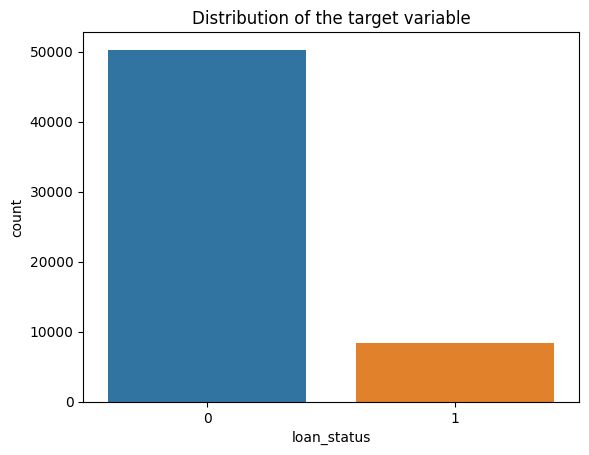

In [58]:
sns.countplot(data=train, x='loan_status')
plt.title('Distribution of the target variable')
plt.show()

### Initial Observations
- The dataset appears to be **imbalanced**
- Roughly 14% of the values belong to `class 1`

### Pointers
- Class imbalance in datasets is often domain-specific and should be carefully evaluated.  
- May require the use of **imbalance handling techniques** (e.g., resampling, synthetic data generation, class weights).  
- **Accuracy alone is not sufficient** for imbalanced datasets. As an exercise, consider which alternative metrics  would be more appropriate, and why.  


## Univariate Feature Analysis

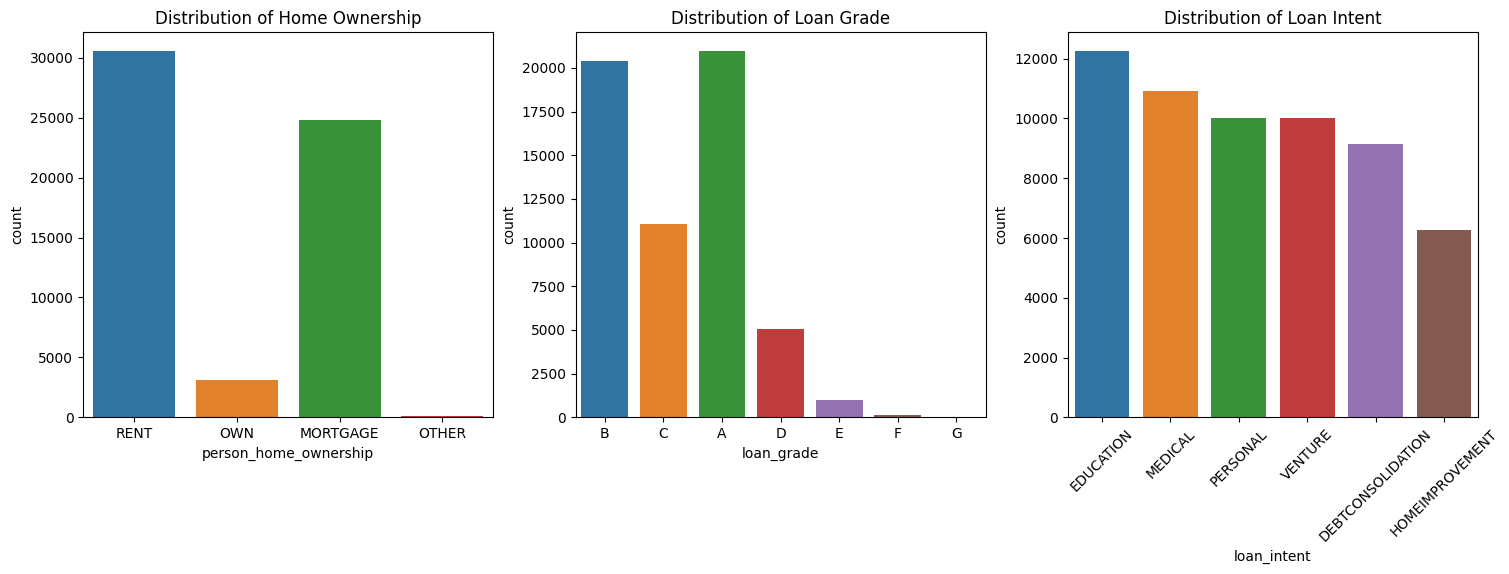

<Figure size 640x480 with 0 Axes>

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(data=train, x="person_home_ownership", ax=axes[0])
axes[0].set_title("Distribution of Home Ownership")

sns.countplot(data=train, x="loan_grade", ax=axes[1])
axes[1].set_title("Distribution of Loan Grade")

sns.countplot(data=train, x="loan_intent", ax=axes[2])
axes[2].set_title("Distribution of Loan Intent")
plt.xticks(rotation=45)
plt.show()

plt.tight_layout()
plt.show()

### Initial Observations
- Some of the categories are more dominant than the others. Can check the connection between categories and the target
- If there are unimportant categories, those can be replaced with a new category "Other"
- Does the loan_grade column have a natural ordering for the alphabets?

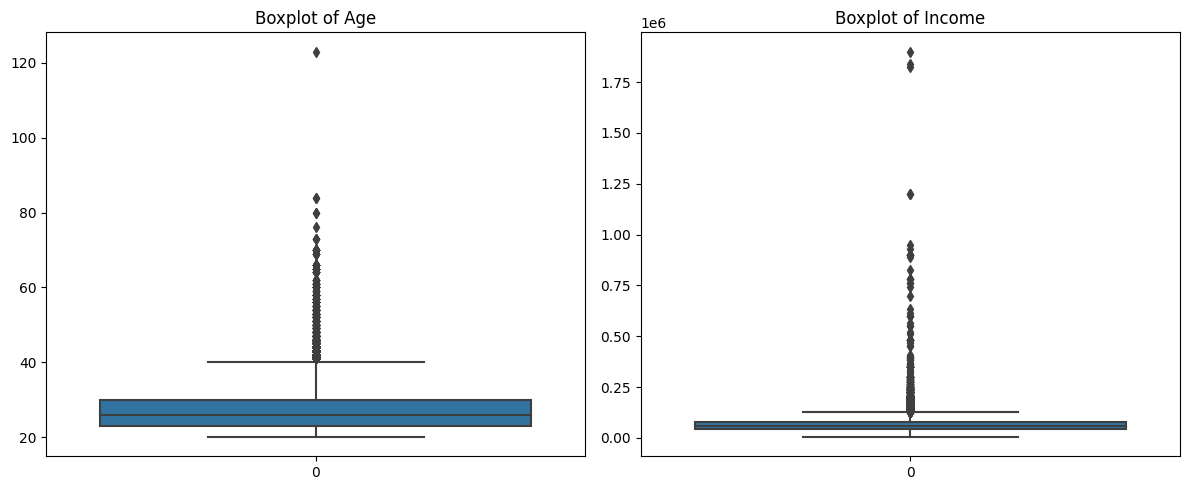

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=train['person_age'], ax=axes[0])
axes[0].set_title("Boxplot of Age")

sns.boxplot(data=train['person_income'], ax=axes[1])
axes[1].set_title("Boxplot of Income")

plt.tight_layout()
plt.show()

### Initial Observations
- The value > 120 in the column `person_age` could be an erroneous entry. Removal would be a good option
- In the case of `person_income`, there are some large values but these could be naturally occuring in the dataset. What are some possible approaches to handle this?

### Pointers
- While claiming points to be outliers (for ex, using a box plot), be clear as to what method is used to label the point as an outlier
- Different methods may select different points as outliers
- It is important to distinguish between outlier values that are naturally occuring & those that are erroneous entries
- In some cases points that are outliers might be the valuable points. For eg: In a *"Money Transaction"* dataset, transactions with a very large amount of money could be indicative of *Fraud*

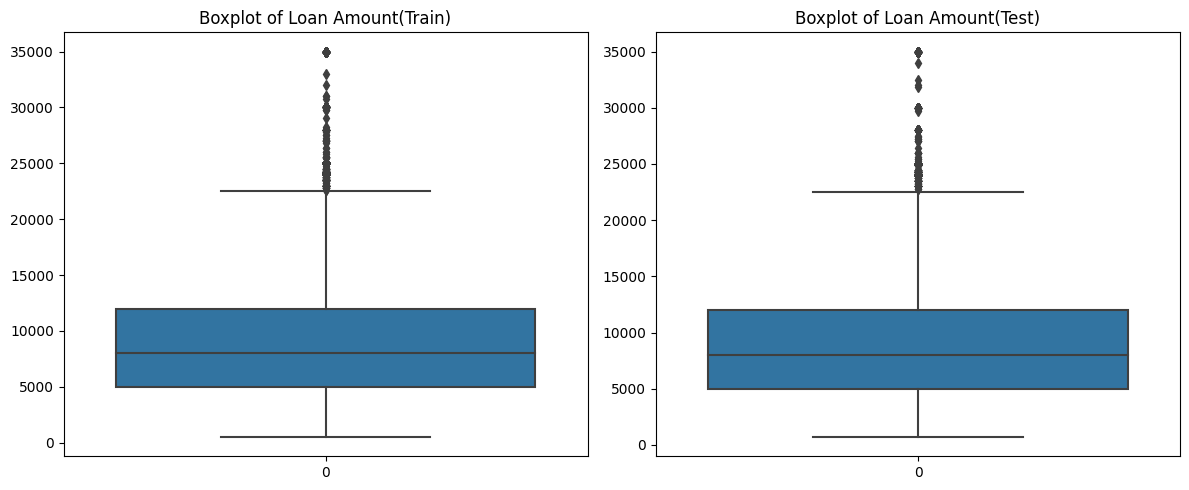

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=train['loan_amnt'], ax=axes[0])
axes[0].set_title("Boxplot of Loan Amount(Train)")

sns.boxplot(data=test['loan_amnt'], ax=axes[1])
axes[1].set_title("Boxplot of Loan Amount(Test)")

plt.tight_layout()
plt.show()

### Initial Observations:
- Even though there appear to be outliers in the boxplot of `loan_amnt` for training data, we can retain them as a similar distribution is observed in the case of test data 

## Bivariate Feature Analysis

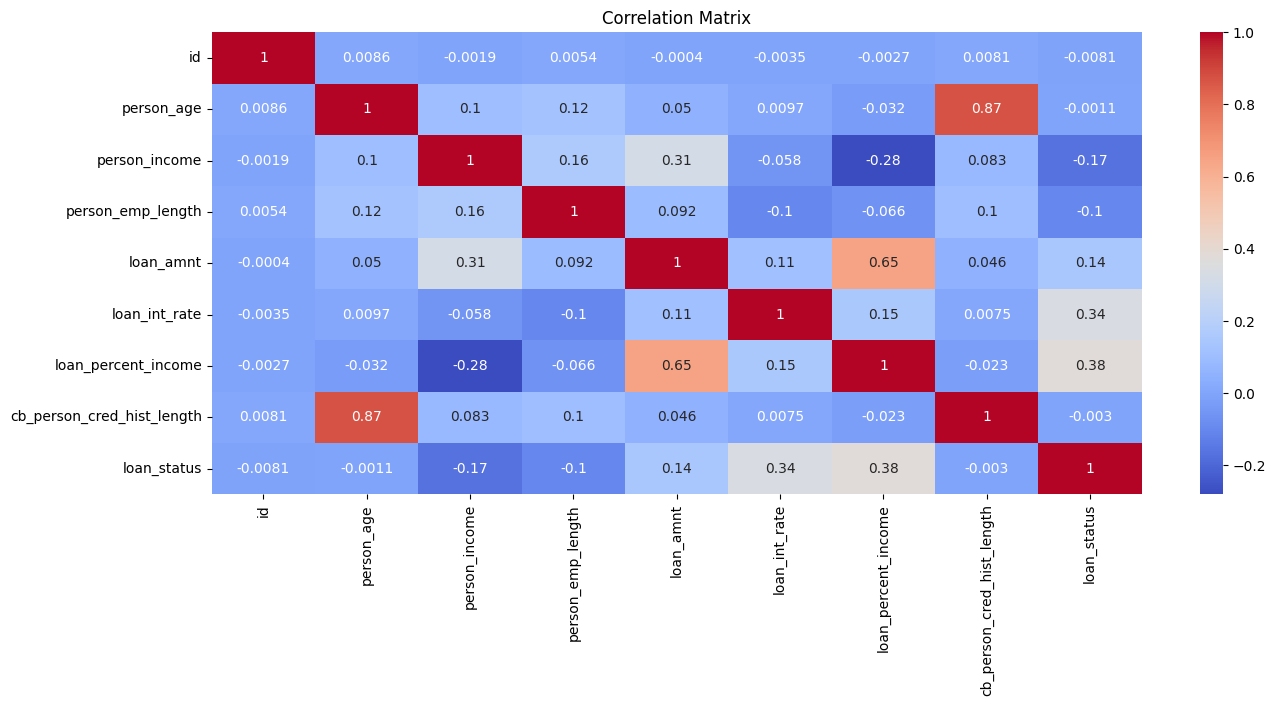

In [62]:
plt.figure(figsize=(15, 6))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Initial Observations:
- The features `cb_person_cred_hist_length` and `person_age` are highly correlated. This is expected as older people would have a longer credit history
- The features `loan_int_rate` and `loan_percent_income` have a higher correlation with the target. These have to be looked at more closely

### Pointers
- Be clear about what correlation is. What is the range of values? What do those values mean?
- What happens if two features are highly correlated? How does it impact various models?
- Are features with strong correlation with the target variable also identified as important features after training a model?

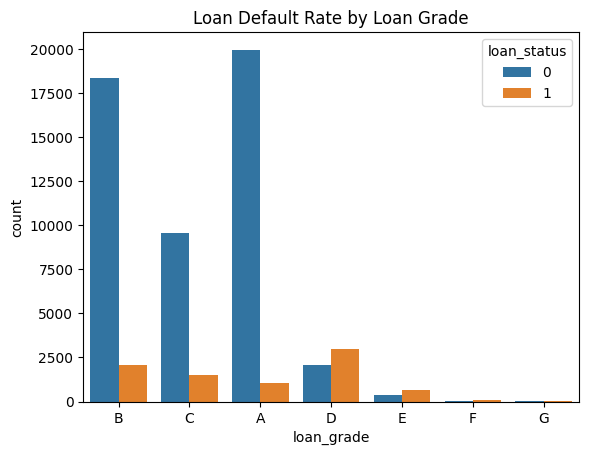

In [63]:
sns.countplot(data=train, x='loan_grade', hue='loan_status')
plt.title('Loan Default Rate by Loan Grade')
plt.show()

Initial Observations:
- The categories D, E, F, G are less frequent than A, B, C. However, in those categories, there are more loans approved than rejected

<Axes: xlabel='loan_status', ylabel='person_income'>

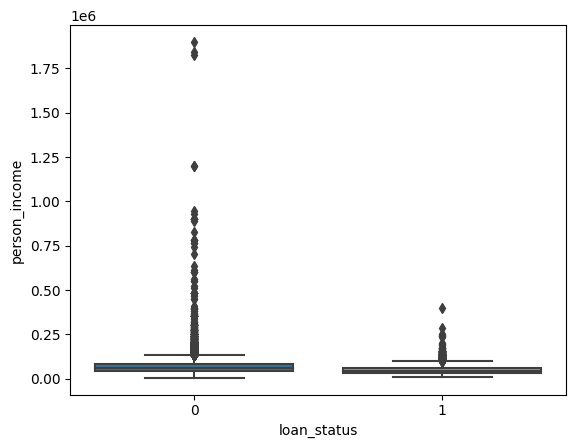

In [64]:
sns.boxplot(x=train['loan_status'],y=train['person_income'])

### Initial Observations
- The income of individuals where the loans were approved appear to be under 500,000

In [65]:
# subset_features = ['loan_amnt', 'loan_int_rate', 'person_income', 'person_age', 'loan_status']
# sns.pairplot(train[subset_features], hue='loan_status')
# plt.title('Pair Plot of Selected Features')
# plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


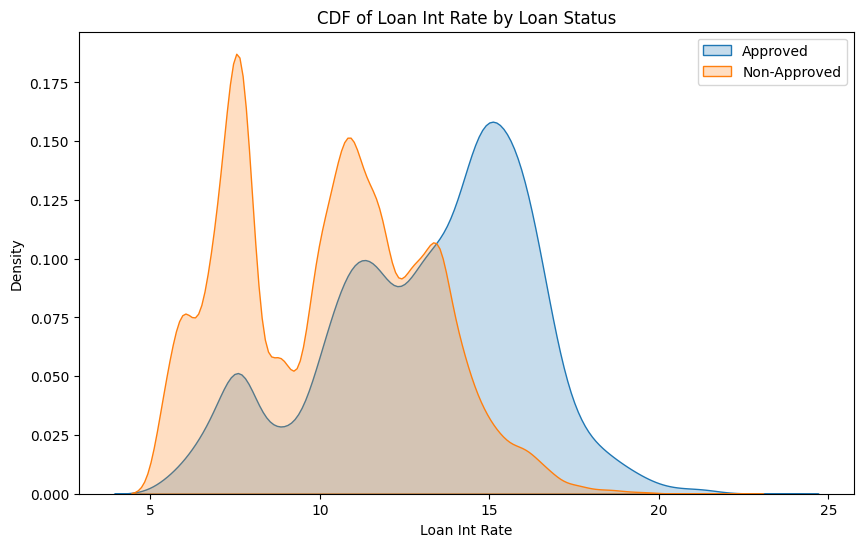

In [66]:
plt.figure(figsize=(10, 6))
sns.kdeplot(train[train['loan_status'] == 1]['loan_int_rate'], label='Approved', fill=True)
sns.kdeplot(train[train['loan_status'] == 0]['loan_int_rate'], label='Non-Approved', fill=True)
plt.title('CDF of Loan Int Rate by Loan Status')
plt.xlabel('Loan Int Rate')
plt.ylabel('Density')
plt.legend()
plt.show()

### Initial Observations
- Loans are more likely to be approved if the interest rates are higher

# Creating a Validation Set

## Why do we need a Validation dataset?
- Train our models to do well on unseen data.
- Identify good values for the HyperParameters through Hyperparameter Tuning

In [67]:
train = train.drop(columns=["id"])
test = test.drop(columns=["id"])

X = train.iloc[:,:-1]
y = train.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Pointers
- The use of stratify can help when there are rare / imbalanced classes
- Repeatedly using the same validation dataset can indirectly lead to overfitting

# Feature Engineering

# Preprocessing

In [68]:
ordinal_col = ["loan_grade"]
onehot_cols = ["person_home_ownership", "loan_intent", "cb_person_default_on_file"]

ordinal_transformer = OrdinalEncoder(categories=[['G', 'F', 'E', 'D', 'C', 'B', 'A']])  
onehot_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("ord", ordinal_transformer, ordinal_col),
        ("ohe", onehot_transformer, onehot_cols)
    ],
    remainder="passthrough"  
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("scaler", MinMaxScaler())
])

### Pointers
- Encoding Categorical variables using One Hot Encoding vs Ordinal vs Target vs Frequency
- Scaling methods. Is it mandatory to use scaling? Which scaler does well even if there are outliers?
- How many features are present after preprocessing?
- Should feature selection methods be used? 

In [69]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

test_processed = pipeline.transform(test)

In [70]:
print(f'The shape of the processed training data is {X_train_processed.shape}')
print(f'The shape of the processed validation data is {X_test_processed.shape}')
print(f'The shape of the processed test data is {test_processed.shape}')

The shape of the processed training data is (46916, 20)
The shape of the processed validation data is (11729, 20)
The shape of the processed test data is (39098, 20)


# Baseline Model

In [71]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_processed, y_train)

y_pred_proba = clf.predict_proba(X_test_processed)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.8964524872116788


### Initial Observations
- The ROC AUC score is fairly high but we have to compare the score with other submissions to understand what a good score would be

### Pointers
- Training the Baseline model is a good point to verify that the data has been preprocessed correctly and is ready for model training
- Usually a simple model (something like the Dummy Classifier) is used for the baseline model. The models trained subsequently should at the very least perform better than the baseline

# Exploring some basic Models

In [72]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42),
    "Bagging": BaggingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    results = {}
    for split, (X, y) in {"Train": (X_train, y_train), "Test": (X_test, y_test)}.items():
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X)

        results[split] = {
            "Accuracy": accuracy_score(y, y_pred),
            "Precision": precision_score(y, y_pred, zero_division=0),
            "Recall": recall_score(y, y_pred, zero_division=0),
            "F1-Score": f1_score(y, y_pred, zero_division=0),
            "ROC-AUC": roc_auc_score(y, y_proba)
        }
    return results

final_results = {}
for name, model in models.items():
    final_results[name] = evaluate_model(model, X_train_processed, y_train, X_test_processed, y_test)

results_df = pd.concat({outer: pd.DataFrame(inner).T for outer, inner in final_results.items()})

print(results_df)

                           Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression Train  0.901100   0.752475  0.455090  0.567164  0.892427
                    Test   0.902293   0.760437  0.458084  0.571749  0.896452
Naive Bayes         Train  0.821234   0.428845  0.770060  0.550897  0.868251
                    Test   0.821980   0.429677  0.764671  0.550194  0.868560
Decision Tree       Train  1.000000   1.000000  1.000000  1.000000  1.000000
                    Test   0.911757   0.678873  0.721557  0.699565  0.832446
Random Forest       Train  0.999936   1.000000  0.999551  0.999775  1.000000
                    Test   0.950891   0.930031  0.708383  0.804215  0.931919
KNN                 Train  0.946585   0.909376  0.694012  0.787230  0.975855
                    Test   0.931196   0.855144  0.622156  0.720277  0.871425
SVM                 Train  0.932177   0.894452  0.593713  0.713694  0.899614
                    Test   0.931537   0.888789  0.593413  0.711670  0.900628

### Initial Observations
- Most of the models have a poor F1-score. This could be due to the imbalance in the target. Scores can be compared once imbalance handling methods are used
- Decision Tree model has overfit on the training dataset but performed poorly on the validation dataset. Tuning hyperparameters such as max_depth would provide more insights
- Adaboost and RandomForest models have performed comparitively better and are good candidates for HyperParameter Tuning
- It would be better to visualize the results through plots

### Pointers
- Certain family of models tend to perform well on certain datasets. Running a preliminary training such as the above can give an idea of which models would do well
- It is important to have a thorough understanding of how models work, what could affect the performance, what are the hyperparameters & how to tune them, some approaches that could potentially improve the score

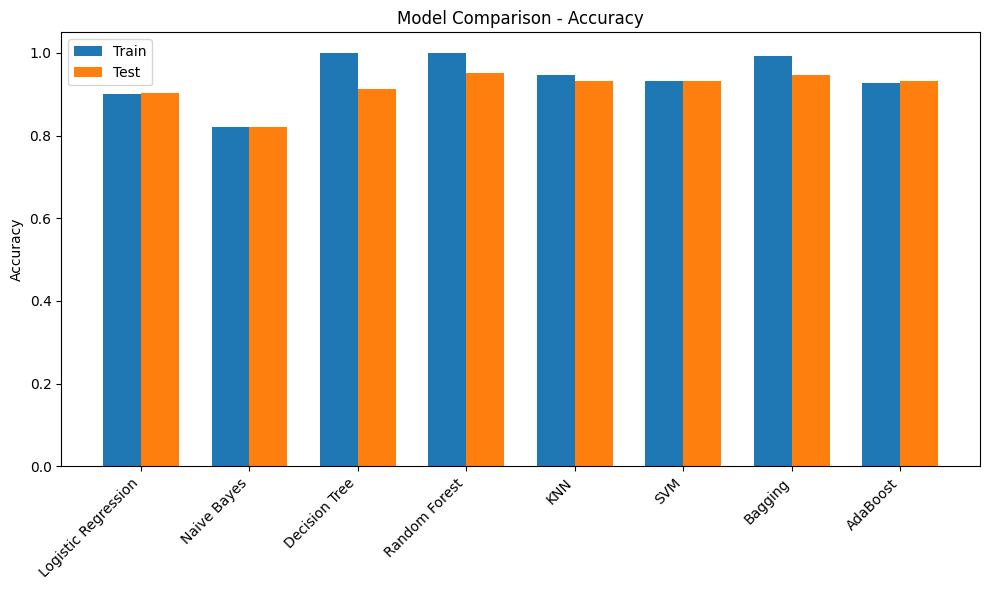

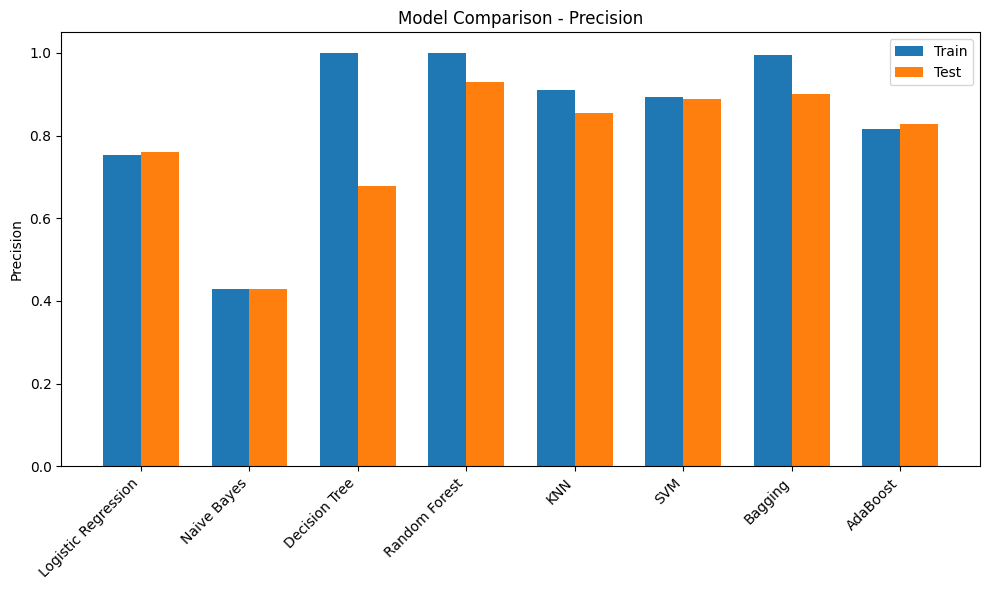

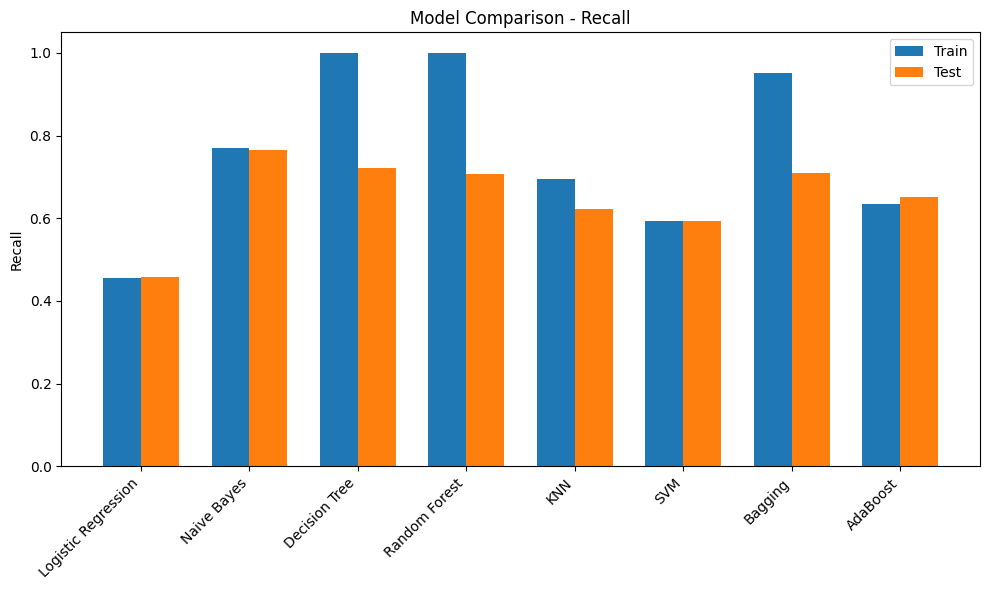

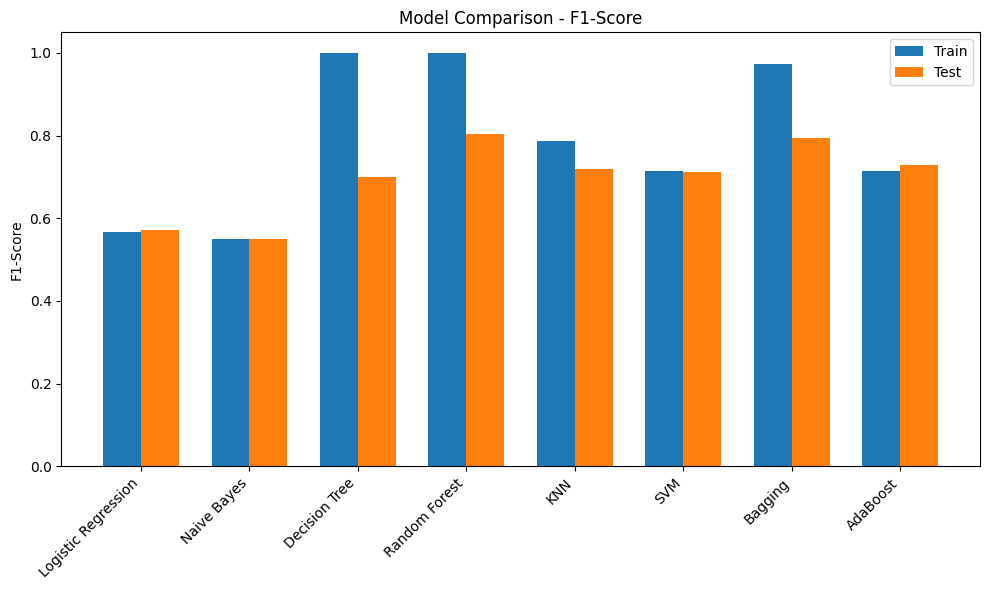

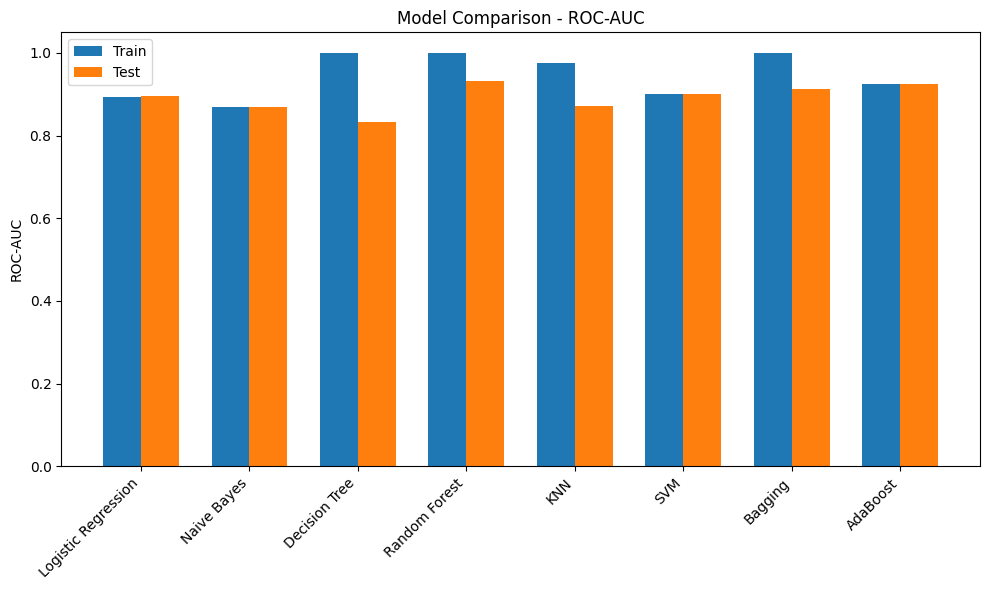

In [73]:
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

for metric in metrics:
    plt.figure(figsize=(10,6))
    train_scores = [final_results[m]["Train"][metric] for m in models.keys()]
    test_scores = [final_results[m]["Test"][metric] for m in models.keys()]
    
    x = np.arange(len(models))
    width = 0.35
    
    plt.bar(x - width/2, train_scores, width, label='Train')
    plt.bar(x + width/2, test_scores, width, label='Test')
    
    plt.xticks(x, models.keys(), rotation=45, ha='right')
    plt.ylabel(metric)
    plt.title(f"Model Comparison - {metric}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Hyperparameter Tuning

In [74]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_processed, y_train)

best_rf = rf_grid.best_estimator_

In [75]:
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

ada_grid = GridSearchCV(AdaBoostClassifier(random_state=42), ada_params, cv=5, scoring='f1', n_jobs=-1)
ada_grid.fit(X_train_processed, y_train)

best_ada = ada_grid.best_estimator_

In [76]:

def evaluate_best_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }

print("Best Random Forest Params:", rf_grid.best_params_)
print("Random Forest Test Performance:", evaluate_best_model(best_rf, X_test_processed, y_test))

print("\nBest AdaBoost Params:", ada_grid.best_params_)
print("AdaBoost Test Performance:", evaluate_best_model(best_ada, X_test_processed, y_test))

Best Random Forest Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Test Performance: {'Accuracy': 0.9514025066075539, 'Precision': 0.9323899371069182, 'Recall': 0.7101796407185629, 'F1-Score': 0.8062542488103331, 'ROC-AUC': 0.9348929638486224}

Best AdaBoost Params: {'learning_rate': 1.0, 'n_estimators': 200}
AdaBoost Test Performance: {'Accuracy': 0.9324750618126012, 'Precision': 0.828101644245142, 'Recall': 0.6634730538922156, 'F1-Score': 0.7367021276595744, 'ROC-AUC': 0.933991337337255}


### Initial Observations
- The models have a slightly higher score after tuning the hyperparameters

### Pointers
- Hyperparameter tuning is about finding the correct settings for the model to extract the best performance
- This could be a time consuming process.
- There are a few more methods for Tuning Hyperparameters such as RandomisedSearchCV and OPTUNA

## XGB Classifier

In [77]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_processed, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_processed)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Test Accuracy: 0.9520845766902549


In [78]:
# best_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc',colsample_bytree= 0.8, learning_rate= 0.1, max_depth= 5, n_estimators= 200, subsample= 1.0 )

# best_model.fit(X_train_processed, y_train)
# y_pred = best_model.predict(X_test_processed)
# print("Test Accuracy:", accuracy_score(y_test, y_pred))

### Pointers
- Boosting based models tend to perform well on Tabular datasets and had dominated Kaggle Leaderboards for a long time
- Hyperparameter Tuning for the XGB model could be slightly challenging. Referring to resouce material and experimenting is recommended

# Model Evaluation

- The performance of the model on the evaluation metric is usually the primary concern in an ML Projects. This decides whether to retain features / outliers, create new features, try out new preprocessing methods...etc.
- It becomes very important to understand the evaluation metric. This could include its mathematical formulation, the range of values it takes and what those values mean in the context of model training.

## ROC AUC curve

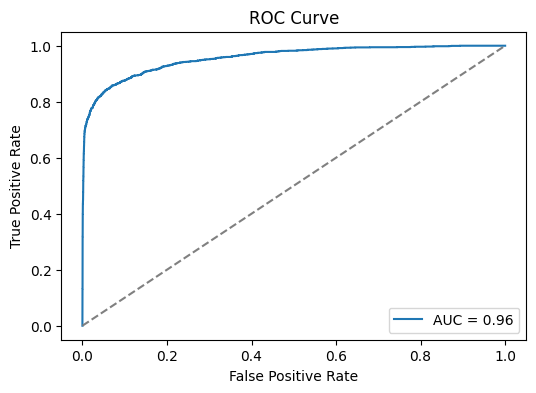

In [79]:
y_proba = best_model.predict_proba(X_test_processed)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--',color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Confusion Matrix

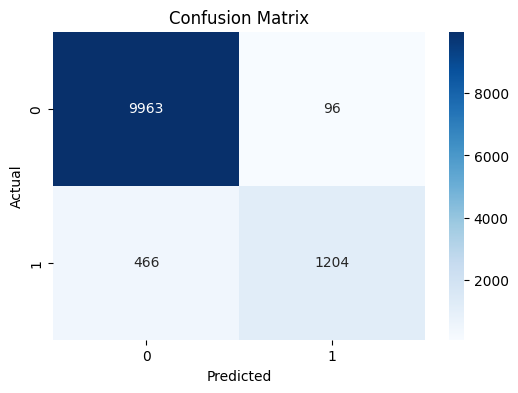

In [80]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Pointers
- Provides a quick count of the points that are classified correctly and incorreclty

## Classification Report

In [81]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     10059
           1       0.93      0.72      0.81      1670

    accuracy                           0.95     11729
   macro avg       0.94      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729



### Pointers
- Provides a snapshot of the performance of the model among the evaluation metrics such as Precision, Recall, F1-score & Accuracy across the various classes
- Allows to easily identify the classes where the model performs poorly. This can allow further analysis on the misclassifications.
- One approach could be to filter the points that are misclassified and experiment with this subset to understand the cause for misclassifications.

## Feature Importance

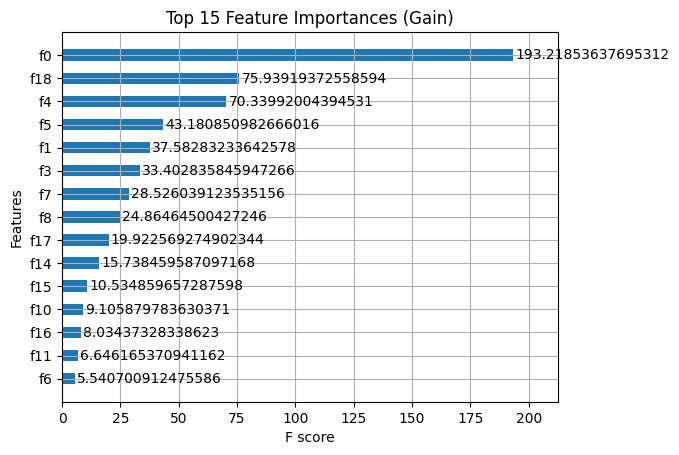

In [82]:
xgb.plot_importance(best_model, importance_type="gain", height=0.5, max_num_features=15)
plt.title("Top 15 Feature Importances (Gain)")
plt.show()

### Pointers
- Feature importance is a valuable tool for explaining model behaviour.
- This can be used to experiment with feature selection

# Submission

In [83]:
final_proba = best_model.predict_proba(test_processed)[:,1]

In [84]:
submission = sample_submission.copy()
submission['loan_status'] = final_proba
submission.to_csv("submission.csv",index=False)

display(submission.head(10))

,id,loan_status
0,58645,0.985335
1,58646,0.017063
2,58647,0.511890
3,58648,0.010022
4,58649,0.038862
5,58650,0.926172
6,58651,0.000750
7,58652,0.006691
8,58653,0.384641
9,58654,0.020374
